In [33]:
t_end = 'Now'
duration_in_day = 330
time_interval = '1h'

Resolved time range: 2025-03-30 18:04:06.155 -> 2026-02-23 18:04:06.155


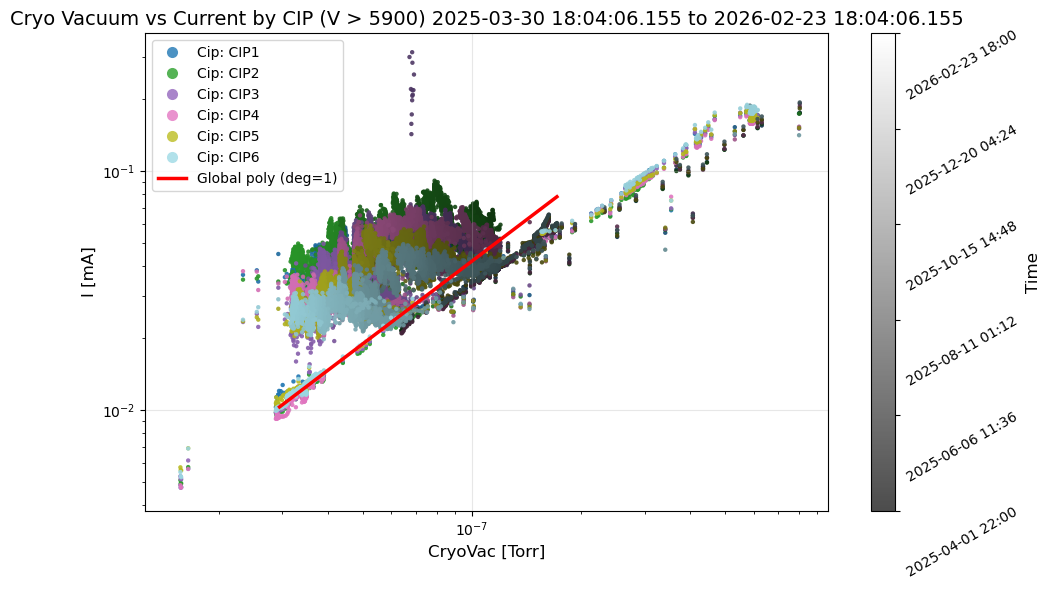

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lsst_efd_client import EfdClient
from astropy.time import Time, TimeDelta
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D

OFFSET = {
    "CIP1": -0.003171139293246799,
    "CIP2": -0.00802408324347602,
    "CIP3": -0.006236367755466037,
    "CIP4": 0.004754777307863589,
    "CIP5": -0.006450745794508193,
    "CIP6": 0.009414226920516402
}
BIN_INFLUX = time_interval
BIN_PANDAS = "1min"

global_poly_coeffs=np.array([ 0.86938622, -5.80271317])
# Use consistent units across notebook: CryoVac [Torr], I [mA]

client = EfdClient("usdf_efd")

def resolve_time_range(t_end_value, duration_days):
    t_end_str = str(t_end_value).strip()
    t_end_val = Time.now() if t_end_str.lower() == "now" else Time(t_end_str)
    t_start_val = t_end_val - TimeDelta(duration_days, format="jd")
    return t_start_val, t_end_val

def result_to_df(result):
    if isinstance(result, pd.DataFrame):
        return result
    if isinstance(result, dict):
        return list(result.values())[0] if result else pd.DataFrame()
    if isinstance(result, list):
        return result[0] if result else pd.DataFrame()
    return pd.DataFrame()

def ensure_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df

def get_query_client(efd_client):
    return (
        getattr(efd_client, "influx_client", None)
        or getattr(efd_client, "_influx_client", None)
    )

async def load_vacuum_data(efd_client, start_time, end_time):
    query_client = get_query_client(efd_client)
    if query_client is not None:
        query1 = f"""SELECT mean("CryoVac") AS "mean_CryoVac" FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.vacuum_cryo" 
        WHERE time > '{start_time.iso}' AND time < '{end_time.iso}' 
        GROUP BY time({BIN_INFLUX}) FILL(null)"""
        query2 = f"""SELECT mean("I") AS "mean_I", mean("V") AS "mean_V" FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.vacuum_cryo_cip" 
        WHERE time > '{start_time.iso}' AND time < '{end_time.iso}' 
        GROUP BY time({BIN_INFLUX}), "Cip" FILL(null)"""

        result1 = await query_client.query(query1)
        result2 = await query_client.query(query2)

        df1 = result_to_df(result1).rename(columns={"mean_CryoVac": "CryoVac"})
        if isinstance(result2, dict):
            dfs_list = [df for df in result2.values() if isinstance(df, pd.DataFrame) and not df.empty]
            df2 = pd.concat(dfs_list) if dfs_list else pd.DataFrame()
        else:
            df2 = result_to_df(result2)
        df2 = df2.rename(columns={"mean_I": "I", "mean_V": "V"})
        return df1, df2

    print("No influx query client found; using select_time_series fallback")
    df1_raw = await efd_client.select_time_series(
        topic_name="lsst.MTCamera.vacuum_cryo",
        fields=["CryoVac"],
        start=start_time,
        end=end_time,
    )
    df2_raw = await efd_client.select_time_series(
        topic_name="lsst.MTCamera.vacuum_cryo_cip",
        fields=["I", "V", "Cip"],
        start=start_time,
        end=end_time,
    )

    df1 = ensure_datetime_index(df1_raw)[["CryoVac"]].resample(BIN_PANDAS).mean()
    df2 = ensure_datetime_index(df2_raw)
    if "I" not in df2.columns or "V" not in df2.columns or "Cip" not in df2.columns:
        raise KeyError(f"Fallback query missing columns. Available: {list(df2.columns)}")
    df2 = (
        df2[["Cip", "I", "V"]]
        .dropna(subset=["Cip"])
        .groupby([pd.Grouper(freq=BIN_PANDAS), "Cip"])[["I", "V"]]
        .mean()
        .reset_index()
        .set_index("time")
    )
    return df1, df2

t_start_val, t_end_val = resolve_time_range(t_end, duration_in_day)
t_start = t_start_val.iso
t_end_iso = t_end_val.iso
print(f"Resolved time range: {t_start} -> {t_end_iso}")

df1, df2 = await load_vacuum_data(client, t_start_val, t_end_val)
df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how="inner")
if df_merged.empty:
    raise ValueError("No merged data found for the selected time range.")
if "V" not in df_merged.columns:
    raise KeyError(f"V column not found after merge. Available columns: {list(df_merged.columns)}")
df_merged = df_merged[df_merged["V"] > 5900].copy()
if df_merged.empty:
    raise ValueError("No data points remain after applying V > 5900 filter.")

fig, ax = plt.subplots(figsize=(10, 6))
unique_cips = df_merged["Cip"].dropna().unique()
base_cmap = plt.get_cmap("tab20", len(unique_cips))
base_colors = [base_cmap(i) for i in range(len(unique_cips))]

time_index = pd.to_datetime(df_merged.index)
time_num = time_index.astype("int64").to_numpy(dtype=float)
time_norm = mcolors.Normalize(vmin=np.nanmin(time_num), vmax=np.nanmax(time_num))
brightness = 0.3 + 0.7 * time_norm(time_num)
brightness = np.asarray(brightness, dtype=float)

legend_handles = []
for i, cip in enumerate(unique_cips):
    mask = df_merged["Cip"] == cip
    base_rgb = np.array(mcolors.to_rgb(base_colors[i]))
    b = brightness[mask.to_numpy()].reshape(-1, 1)
    colors = np.clip(base_rgb * b, 0, 1).astype(float)
    ax.scatter(
        df_merged.loc[mask, "CryoVac"],
        (df_merged.loc[mask, "I"] - OFFSET.get(cip, 0.0)),
        color=colors, alpha=0.9, s=10, edgecolors="none"
    )
    legend_color = np.clip(base_rgb * 0.8 + 0.2, 0, 1)
    legend_handles.append(
        Line2D(
            [0], [0], marker="o", linestyle="None",
            markerfacecolor=legend_color, markeredgecolor="none", markersize=8,
            label=f"Cip: {cip}"
        )
    )

# Overlay polynomial fit results from Cell 4 (per-CIP) and Cell 5 (global)
log_base_for_plot = int(globals().get("LOG_BASE", 10))

def _log_transform_for_plot(v, base):
    return np.log10(v) if base == 10 else np.log(v)

def _inv_log_transform_for_plot(v, base):
    return 10 ** v if base == 10 else np.exp(v)


if "global_poly_coeffs" in globals() and global_poly_coeffs is not None:
    i_corr_ma_all = (df_merged["I"] - df_merged["Cip"].map(OFFSET).fillna(0.0)).to_numpy(dtype=float)
    valid_global = np.isfinite(i_corr_ma_all) & (i_corr_ma_all > 0)
    if np.count_nonzero(valid_global) > 2:
##       i_line_ma = np.logspace(np.log10(np.nanmin(i_corr_ma_all[valid_global])), np.log10(np.nanmax(i_corr_ma_all[valid_global])), 300)
        i_line_ma = np.logspace(-1.9879937236649605, -1.1068178452766648, 300)
        ly = np.polyval(global_poly_coeffs, _log_transform_for_plot(i_line_ma, log_base_for_plot))
        x_line_torr = _inv_log_transform_for_plot(ly, log_base_for_plot)
        y_line_ma = i_line_ma

        deg_text = int(globals().get("global_poly_degree", len(global_poly_coeffs) - 1))
        ax.plot(x_line_torr, y_line_ma, color="red", linewidth=2.5)
        legend_handles.append( 
            Line2D([0], [0], color="red", linewidth=2.5, label=f"Global poly (deg={deg_text})")
        )
else:
    print("Cell 5 global polynomial result not found. Run Cell 5 to overlay global polynomial curve.")

bright_greys = mcolors.LinearSegmentedColormap.from_list(
    "bright_greys", [(0.3, 0.3, 0.3), (1, 1, 1)]
)
sm = plt.cm.ScalarMappable(cmap=bright_greys, norm=time_norm)
sm.set_array([])
ticks = np.linspace(np.nanmin(time_num), np.nanmax(time_num), 6)
cbar = fig.colorbar(sm, ax=ax, ticks=ticks)
cbar.set_label("Time", fontsize=12)
tick_labels = pd.to_datetime(ticks).strftime("%Y-%m-%d %H:%M")
cbar.ax.set_yticklabels(tick_labels, rotation=30)

ax.set_xlabel("CryoVac [Torr]", fontsize=12)
ax.set_ylabel("I [mA]", fontsize=12)
x_plot = df_merged["CryoVac"].to_numpy(dtype=float)
y_plot = (df_merged["I"] - df_merged["Cip"].map(OFFSET).fillna(0.0)).to_numpy(dtype=float)
valid_plot = np.isfinite(x_plot) & np.isfinite(y_plot) & (x_plot > 0) & (y_plot > 0)
if np.count_nonzero(valid_plot) > 1:
    ax.set_xlim(np.nanmin(x_plot[valid_plot]) * 0.8, np.nanmax(x_plot[valid_plot]) * 1.2)
    ax.set_ylim(np.nanmin(y_plot[valid_plot]) * 0.8, np.nanmax(y_plot[valid_plot]) * 1.2)
ax.loglog()
ax.set_title(f"Cryo Vacuum vs Current by CIP (V > 5900) {t_start} to {t_end_iso}", fontsize=14)
ax.legend(handles=legend_handles)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

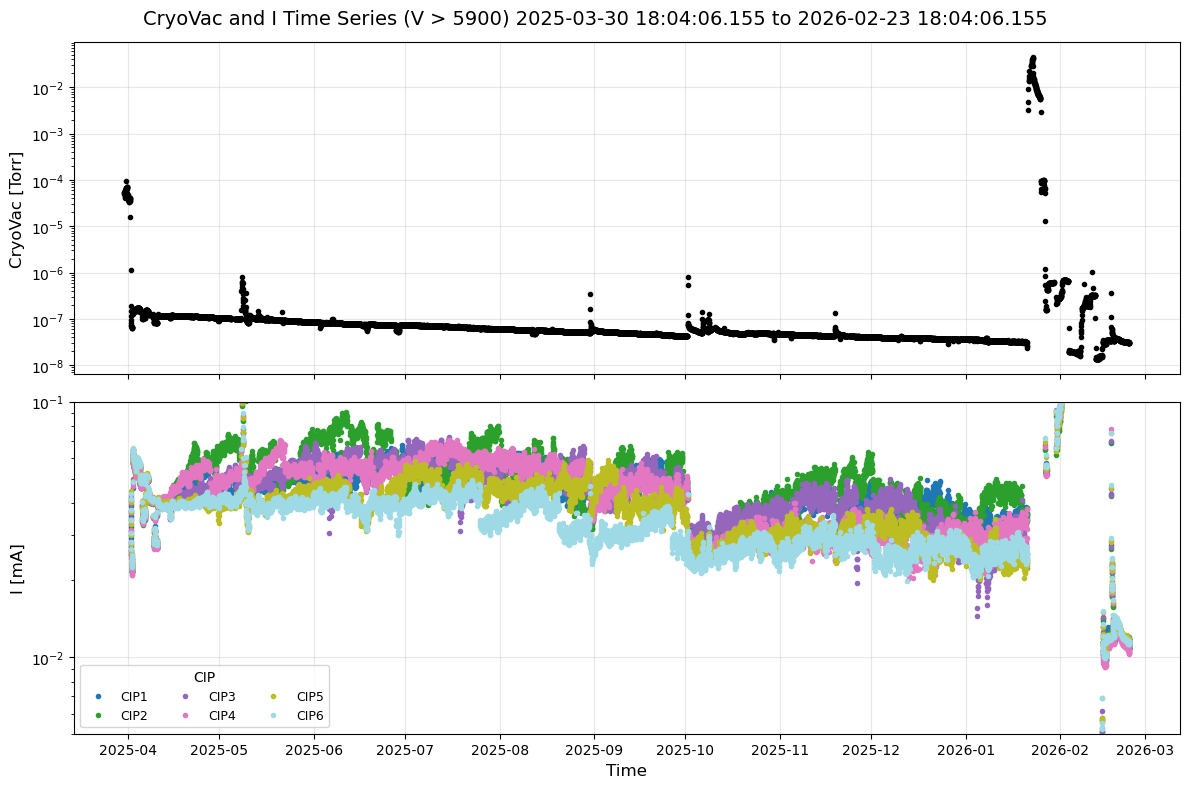

In [57]:
# Time-series plot: CryoVac and I for each CIP
if "df1" not in globals() or "df2" not in globals():
    raise RuntimeError("Run Cell 2 first to load df1/df2.")

df_cryo = df1.copy().rename(columns={"mean_CryoVac": "CryoVac"})
df_i = df2.copy().rename(columns={"mean_I": "I", "mean_V": "V"})

required_df1 = {"CryoVac"}
required_df2 = {"I", "V", "Cip"}
if df_cryo.empty or df_i.empty:
    raise ValueError("CryoVac or I data is empty. Check query results in Cell 2.")
if not required_df1.issubset(df_cryo.columns) or not required_df2.issubset(df_i.columns):
    raise KeyError(f"Missing required columns. df1={list(df_cryo.columns)}, df2={list(df_i.columns)}")

df_i = df_i[df_i["V"] > 5900].copy()
if df_i.empty:
    raise ValueError("No I data after applying V > 5900 filter in Cell 3.")

df_cryo = df_cryo.sort_index()
df_i = df_i.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# CryoVac vs time
ax1.plot(df_cryo.index, df_cryo["CryoVac"], ".", color="black", linewidth=2)
ax1.set_ylabel("CryoVac [Torr]", fontsize=12)
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)

# I vs time for each CIP
cips = sorted(df_i["Cip"].dropna().unique())
cmap = plt.get_cmap("tab20", len(cips))
for i, cip in enumerate(cips):
    sub = df_i[df_i["Cip"] == cip]
    y = sub["I"] - OFFSET.get(cip, 0.0)
    ax2.plot(sub.index, y, ".", linewidth=1.5, color=cmap(i), label=f"{cip}")

ax2.set_ylabel("I [mA]", fontsize=12)
ax2.set_xlabel("Time", fontsize=12)
ax2.set_yscale("log")
ax2.set_ylim(0.5e-2,1e-1)
ax2.grid(True, alpha=0.3)
ax2.legend(title="CIP", ncol=3, fontsize=9)

plot_title = (
    f"CryoVac and I Time Series (V > 5900) {t_start} to {t_end_iso}"
    if "t_start" in globals() and "t_end_iso" in globals()
    else "CryoVac and I Time Series (V > 5900)"
 )
fig.suptitle(plot_title, fontsize=14)
plt.tight_layout()
plt.show()

In [58]:
POLY_DEGREE=1

,CIP,degree,log_base,n_total,n_positive,n_inliers,status,c1,c0
0,CIP1,1,10,7275,7275,7212,ok,0.690122,-6.282055
1,CIP2,1,10,7275,7275,7153,ok,0.520029,-6.540190
2,CIP3,1,10,7275,7275,7146,ok,0.634963,-6.357735
3,CIP4,1,10,7275,7275,7099,ok,0.643967,-6.338907
4,CIP5,1,10,7275,7275,7195,ok,0.846783,-6.007741
5,CIP6,1,10,7275,7275,7270,ok,1.163563,-5.491159


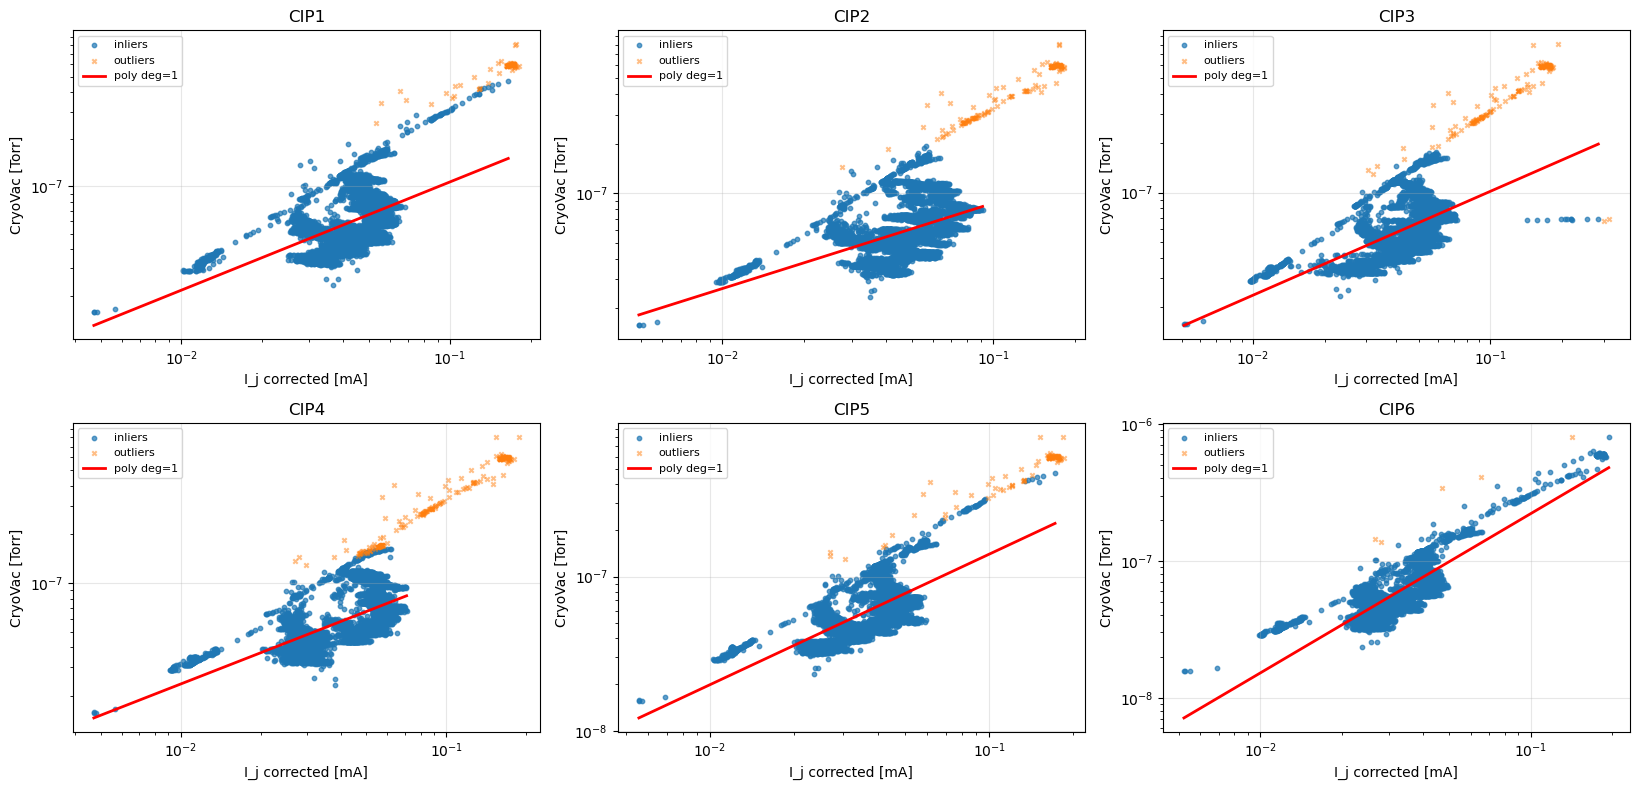

In [59]:
# Robust log-log polynomial fit for each CIP
if "df_merged" not in globals():
    raise RuntimeError("Run Cell 2 first to build df_merged.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set polynomial degree n here (or define POLY_DEGREE in another cell before running)
POLY_DEGREE = int(globals().get("POLY_DEGREE", 2))
LOG_BASE = int(globals().get("LOG_BASE", 10))

def log_transform(v, base):
    if base == 10:
        return np.log10(v)
    return np.log(v)

def inv_log_transform(v, base):
    if base == 10:
        return 10 ** v
    return np.exp(v)

def robust_poly_loglog_fit(x, y, degree=2, sigma=3.5, max_iter=8, min_points=None, log_base=10):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if min_points is None:
        min_points = max(12, degree + 4)

    valid = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x = x[valid]
    y = y[valid]

    if x.size < min_points:
        return None, np.zeros_like(valid, dtype=bool), "insufficient positive points"

    lx = log_transform(x, log_base)
    ly = log_transform(y, log_base)

    inlier_local = np.ones_like(lx, dtype=bool)
    for _ in range(max_iter):
        if np.count_nonzero(inlier_local) < min_points:
            return None, np.zeros_like(valid, dtype=bool), "insufficient inliers"

        coeffs = np.polyfit(lx[inlier_local], ly[inlier_local], degree)
        resid = ly - np.polyval(coeffs, lx)
        med = np.median(resid[inlier_local])
        mad = np.median(np.abs(resid[inlier_local] - med))

        if mad == 0 or not np.isfinite(mad):
            break

        robust_sigma = 1.4826 * mad
        new_inlier_local = np.abs(resid - med) <= sigma * robust_sigma

        if np.array_equal(new_inlier_local, inlier_local):
            inlier_local = new_inlier_local
            break
        inlier_local = new_inlier_local

    if np.count_nonzero(inlier_local) < min_points:
        return None, np.zeros_like(valid, dtype=bool), "insufficient inliers after clipping"

    coeffs = np.polyfit(lx[inlier_local], ly[inlier_local], degree)

    inlier_full = np.zeros_like(valid, dtype=bool)
    inlier_full[np.where(valid)[0][inlier_local]] = True
    return coeffs, inlier_full, "ok"

x_col = "I"
y_col = "CryoVac"
cips = sorted(df_merged["Cip"].dropna().unique())
coef_labels = [f"c{k}" for k in range(POLY_DEGREE, -1, -1)]

fit_rows = []
fit_cache = {}
poly_coeffs_by_cip = {}

for cip in cips:
    sub = df_merged[df_merged["Cip"] == cip].copy()
    sub["I_corr"] = sub[x_col] - OFFSET.get(cip, 0.0)

    coeffs, inlier_mask, status = robust_poly_loglog_fit(
        sub["I_corr"].to_numpy(),
        sub[y_col].to_numpy(),
        degree=POLY_DEGREE,
        log_base=LOG_BASE,
    )

    n_total = len(sub)
    valid_pos = np.isfinite(sub["I_corr"].to_numpy()) & np.isfinite(sub[y_col].to_numpy()) & (sub["I_corr"].to_numpy() > 0) & (sub[y_col].to_numpy() > 0)
    n_positive = int(np.count_nonzero(valid_pos))
    n_inliers = int(np.count_nonzero(inlier_mask))

    row = {
        "CIP": cip,
        "degree": POLY_DEGREE,
        "log_base": LOG_BASE,
        "n_total": n_total,
        "n_positive": n_positive,
        "n_inliers": n_inliers,
        "status": status,
    }
    for idx, label in enumerate(coef_labels):
        row[label] = np.nan if coeffs is None else coeffs[idx]
    fit_rows.append(row)

    poly_coeffs_by_cip[cip] = coeffs
    fit_cache[cip] = {
        "x": sub["I_corr"].to_numpy(dtype=float),
        "y": sub[y_col].to_numpy(dtype=float),
        "inlier": inlier_mask,
        "coeffs": coeffs,
    }

fit_poly_df = pd.DataFrame(fit_rows).sort_values("CIP")
display(fit_poly_df)

# Diagnostic plot (original domain, log-log axes)
n = len(cips)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.0 * nrows))
axes = np.atleast_1d(axes).ravel()

for i, cip in enumerate(cips):
    ax = axes[i]
    d = fit_cache[cip]
    x = d["x"]
    y = d["y"]
    m = d["inlier"]
    coeffs = d["coeffs"]

    valid_pos = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    inl = valid_pos & m
    outl = valid_pos & (~m)

    ax.scatter(x[inl], y[inl], s=10, alpha=0.7, label="inliers")
    ax.scatter(x[outl], y[outl], s=10, alpha=0.5, marker="x", label="outliers")

    if coeffs is not None and np.count_nonzero(inl) > 2:
        xs = np.logspace(np.log10(np.nanmin(x[inl])), np.log10(np.nanmax(x[inl])), 200)
        ly = np.polyval(coeffs, log_transform(xs, LOG_BASE))
        ys = inv_log_transform(ly, LOG_BASE)
        ax.plot(xs, ys, "r-", linewidth=2, label=f"poly deg={POLY_DEGREE}")

    ax.set_title(f"{cip}")
    ax.set_xlabel("I_j corrected [mA]")
    ax.set_ylabel("CryoVac [Torr]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

,fit_scope,degree,log_base,n_total,n_positive,n_inliers,status,c1,c0
0,ALL_CIP,1,10,43650,43650,42942,ok,0.607201,-6.381254


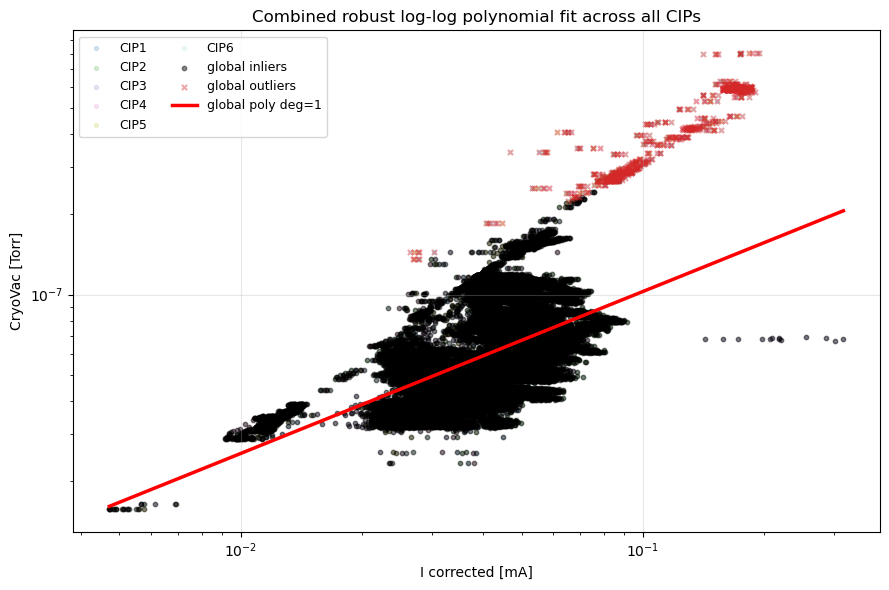

In [60]:
# Combined robust log-log polynomial fit across all CIPs
if "df_merged" not in globals():
    raise RuntimeError("Run Cell 2 first to build df_merged.")
if "robust_poly_loglog_fit" not in globals():
    raise RuntimeError("Run Cell 4 first to define robust_poly_loglog_fit.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

degree = int(globals().get("POLY_DEGREE", 2))
log_base = int(globals().get("LOG_BASE", 10))

# Build combined dataset using offset-corrected current
df_all = df_merged.copy()
df_all["I_corr"] = df_all.apply(
    lambda r: r["I"] - OFFSET.get(r["Cip"], 0.0),
    axis=1,
)

coeffs_all, inlier_mask_all, status_all = robust_poly_loglog_fit(
    df_all["I_corr"].to_numpy(),
    df_all["CryoVac"].to_numpy(),
    degree=degree,
    log_base=log_base,
)

x_all = df_all["I_corr"].to_numpy(dtype=float)
y_all = df_all["CryoVac"].to_numpy(dtype=float)
valid_pos_all = np.isfinite(x_all) & np.isfinite(y_all) & (x_all > 0) & (y_all > 0)
inl_all = valid_pos_all & inlier_mask_all
outl_all = valid_pos_all & (~inlier_mask_all)

coef_labels = [f"c{k}" for k in range(degree, -1, -1)]
summary_row = {
    "fit_scope": "ALL_CIP",
    "degree": degree,
    "log_base": log_base,
    "n_total": int(len(df_all)),
    "n_positive": int(np.count_nonzero(valid_pos_all)),
    "n_inliers": int(np.count_nonzero(inl_all)),
    "status": status_all,
}
for idx, label in enumerate(coef_labels):
    summary_row[label] = np.nan if coeffs_all is None else coeffs_all[idx]

summary_poly_df = pd.DataFrame([summary_row])
display(summary_poly_df)

# Save for Cell 2 overlay (no re-fitting in Cell 2)
global_poly_coeffs = coeffs_all
global_poly_degree = degree
global_poly_log_base = log_base

fig, ax = plt.subplots(figsize=(9, 6))

# Lightly show all points by CIP color
cips_all = sorted(df_all["Cip"].dropna().unique())
cmap = plt.get_cmap("tab20", len(cips_all))
for i, cip in enumerate(cips_all):
    s = df_all[df_all["Cip"] == cip]
    xx = s["I_corr"].to_numpy(dtype=float)
    yy = s["CryoVac"].to_numpy(dtype=float)
    vv = np.isfinite(xx) & np.isfinite(yy) & (xx > 0) & (yy > 0)
    ax.scatter(xx[vv], yy[vv], s=8, alpha=0.18, color=cmap(i), label=cip)

# Overlay global inliers/outliers
ax.scatter(x_all[inl_all], y_all[inl_all], s=10, alpha=0.45, color="k", label="global inliers")
ax.scatter(x_all[outl_all], y_all[outl_all], s=14, alpha=0.4, marker="x", color="tab:red", label="global outliers")

# Plot global polynomial curve
if coeffs_all is not None and np.count_nonzero(inl_all) > 2:
    xs = np.logspace(np.log10(np.nanmin(x_all[inl_all])), np.log10(np.nanmax(x_all[inl_all])), 300)
    ly = np.polyval(coeffs_all, log_transform(xs, log_base))
    ys = inv_log_transform(ly, log_base)
    ax.plot(xs, ys, "r-", linewidth=2.5, label=f"global poly deg={degree}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("I corrected [mA]")
ax.set_ylabel("CryoVac [Torr]")
ax.set_title("Combined robust log-log polynomial fit across all CIPs")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [47]:

global_poly_coeffs

array([ 0.60778886, -6.38042046])